### Machine Learning for Music

#### About

This notebook is my first attempt at music analysis with music21. It's inspired by Waldecir Faria's article: https://towardsdatascience.com/midi-music-data-extraction-using-music21-and-word2vec-on-kaggle-cb383261cd4e.

Let's begin by loading some MIDI data. I'll go with Mozart.

In [145]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 100]          

    return midi.translate.midiFileToStream(mf)

In [146]:
midi1 = open_midi("C:/Users/basia/OneDrive/Pulpit/Mozart/MIDI/Opera/cosi_fan_tutte__soave_il_vento.mid", False)
midi1.show('midi')

In [147]:
midi2 = open_midi("C:/Users/basia/OneDrive/Pulpit/Mozart/Sonatina n3 1mov.mid", False)
midi2.show('midi')

In [148]:
midi3 = open_midi("C:/Users/basia/OneDrive/Pulpit/Mozart/K393 Solfeggi n1.mid", False)
midi3.show('midi')

Waldecir writes a nice set of functions that visualize music as dots in a chart....

In [149]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()


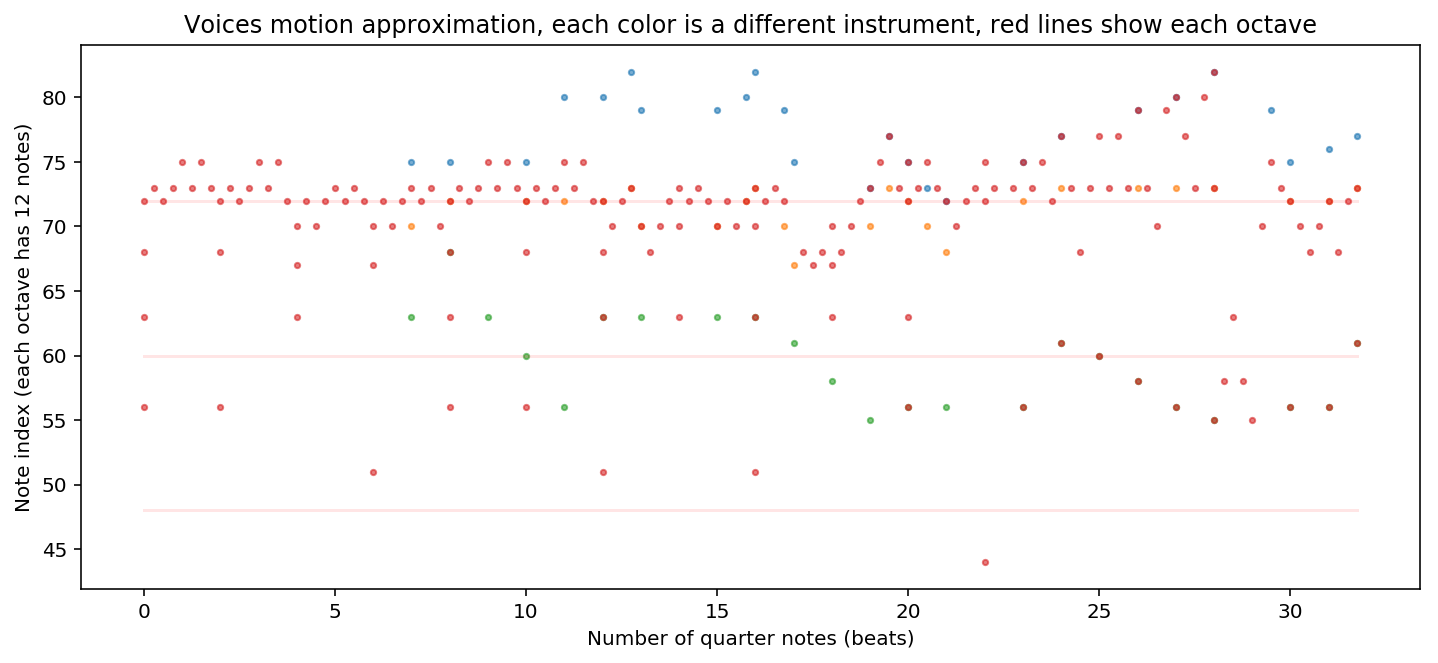

In [150]:
# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(midi1.measures(0, 8))

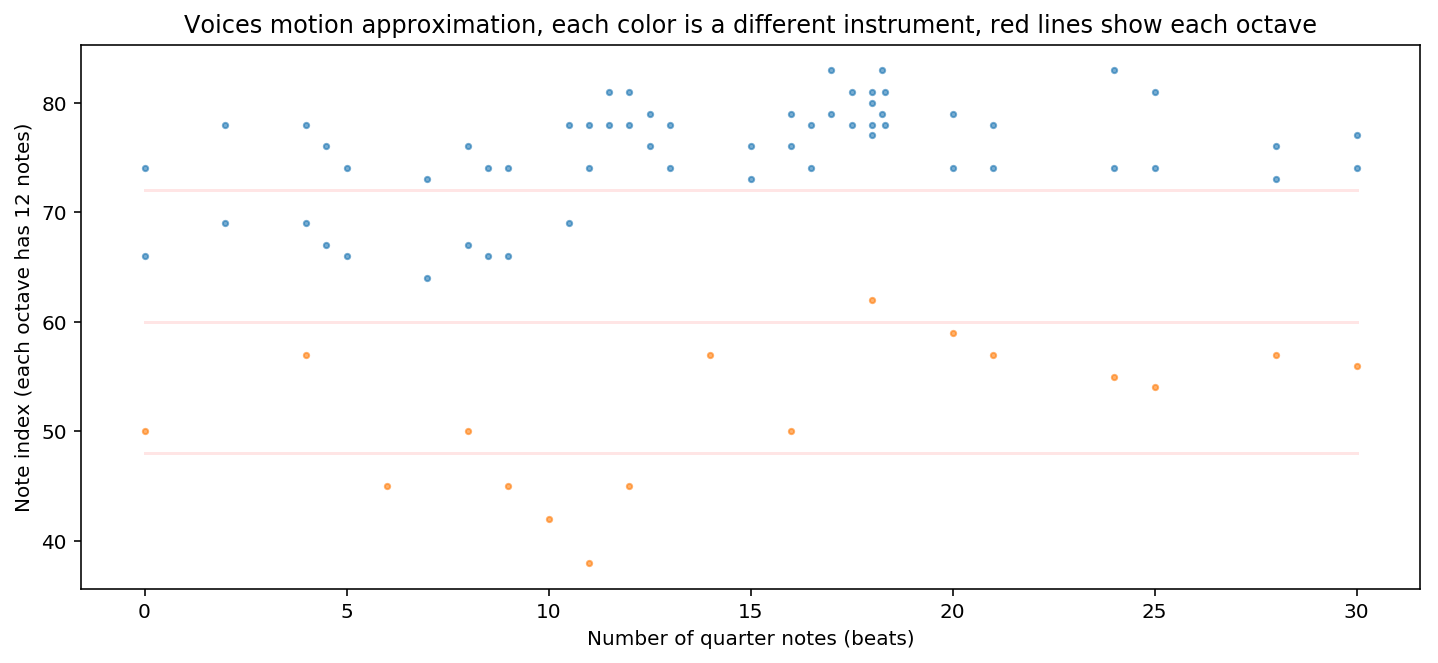

In [151]:
print_parts_countour(midi2.measures(0, 8))

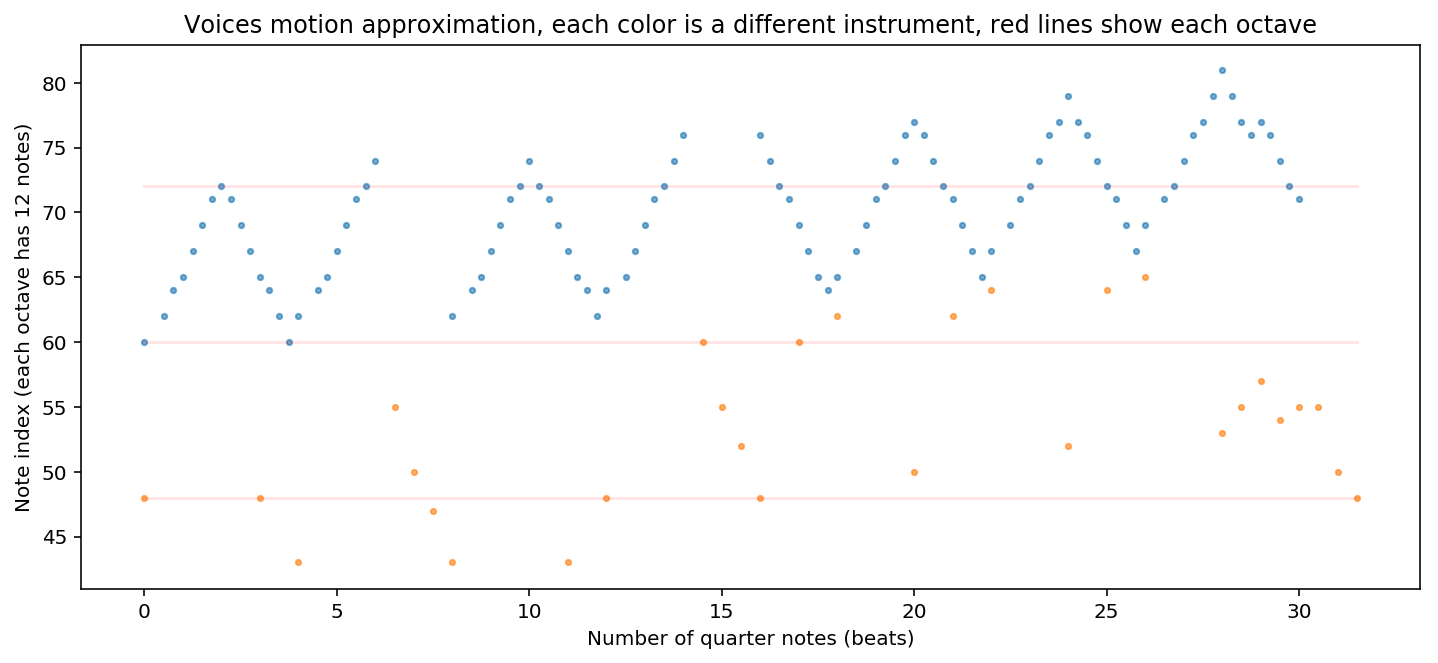

In [152]:
print_parts_countour(midi3.measures(0, 8))

...then collapses all tracks into a single track, to analyze the chords.

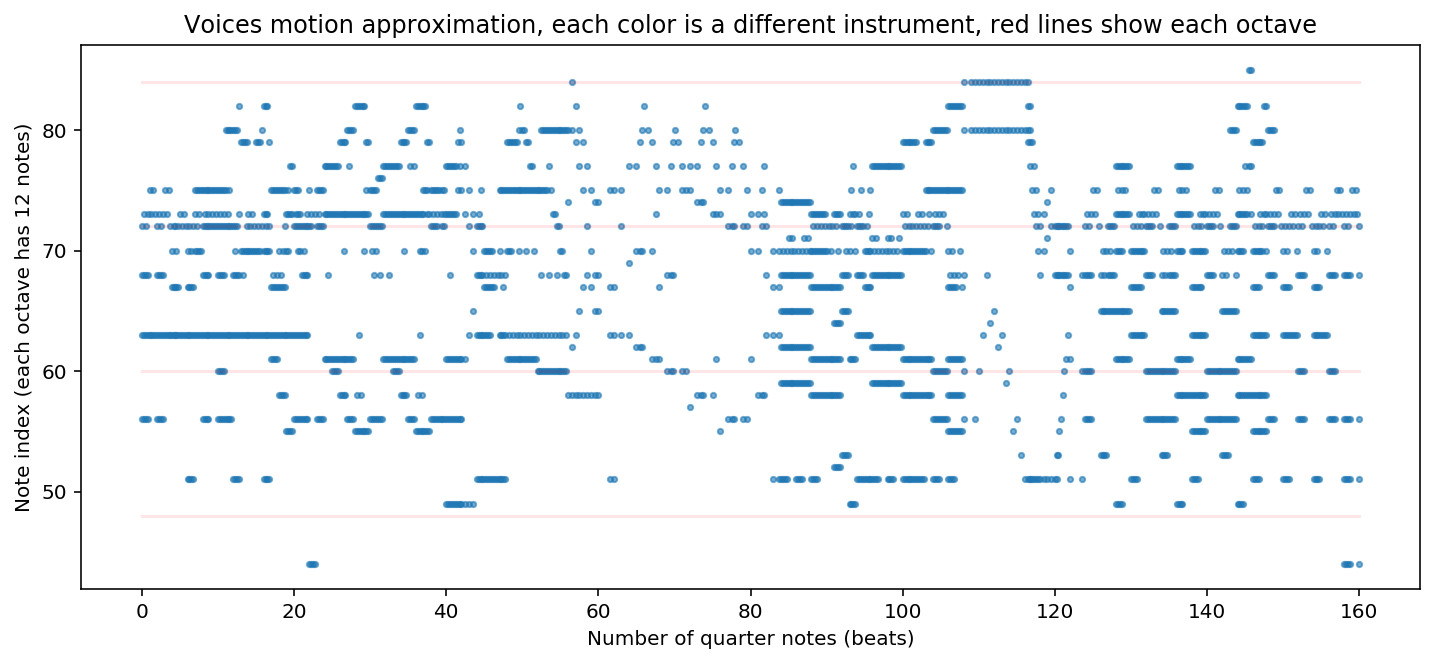

In [153]:
from music21 import stream

temp_midi_chords = open_midi(
    "C:/Users/basia/OneDrive/Pulpit/Mozart/MIDI/Opera/cosi_fan_tutte__soave_il_vento.mid",
    True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
#temp_midi_chords.measures(0, 1).show("text")

This next section converts chords into Roman numerals, which denote the root note on which the chord is built.

In [154]:
from music21 import roman

def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret
                
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

In [155]:
harmonic_reduction(midi1)[0:10]

['#iii64',
 'iii65',
 'iii64',
 'iii65',
 'V53',
 'iii64',
 'vi',
 'iii',
 'vi',
 '#iii']

In [156]:
harmonic_reduction(midi2)[0:10]

['I', 'I64', 'I', 'I64', 'I', 'I', 'vi43', '-III65', 'V7', 'I']

In [157]:
harmonic_reduction(midi3)[0:10]

['ii', 'I53', 'I', 'IV53', 'v42', 'vi42', '-VII42', 'I', 'IV42', 'V42']

Next, we try to determine the key of each piece, by analyzing individual note frequencies.

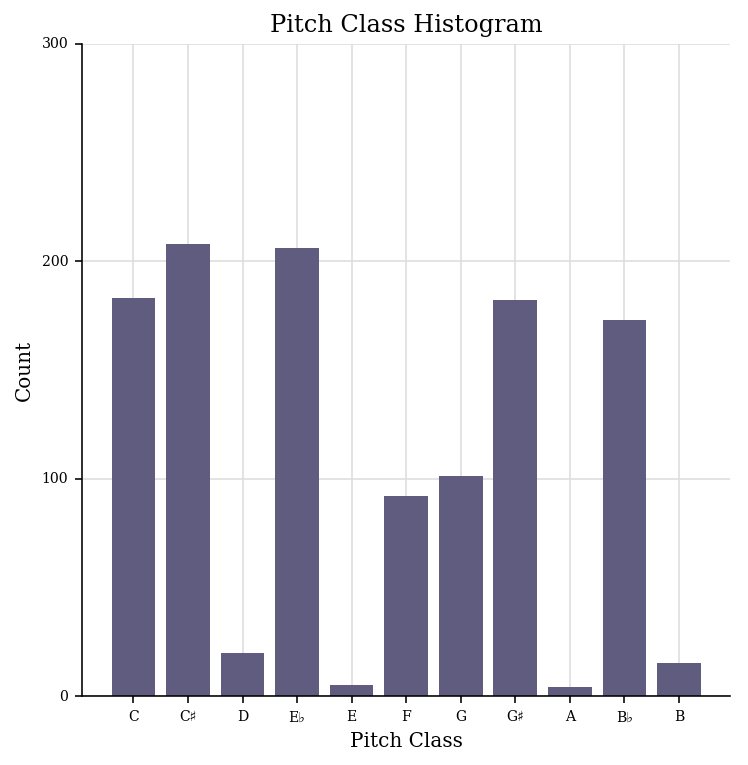

In [158]:
midi1.plot('histogram', 'pitchClass', 'count')

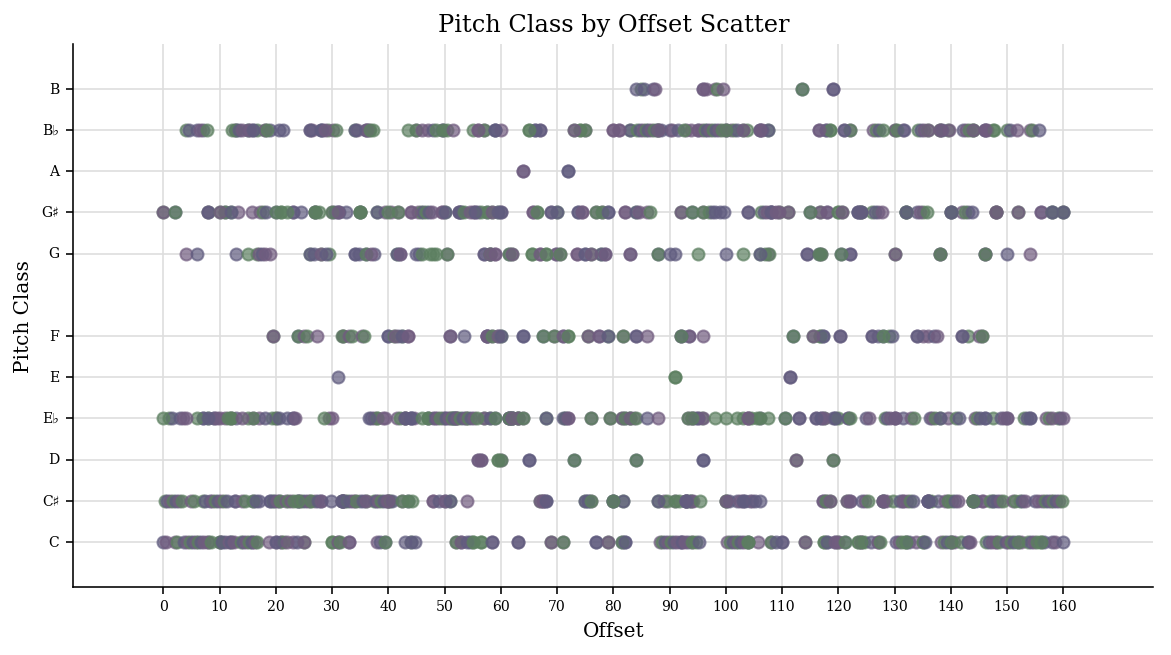

In [159]:
midi1.plot('scatter', 'offset', 'pitchClass')

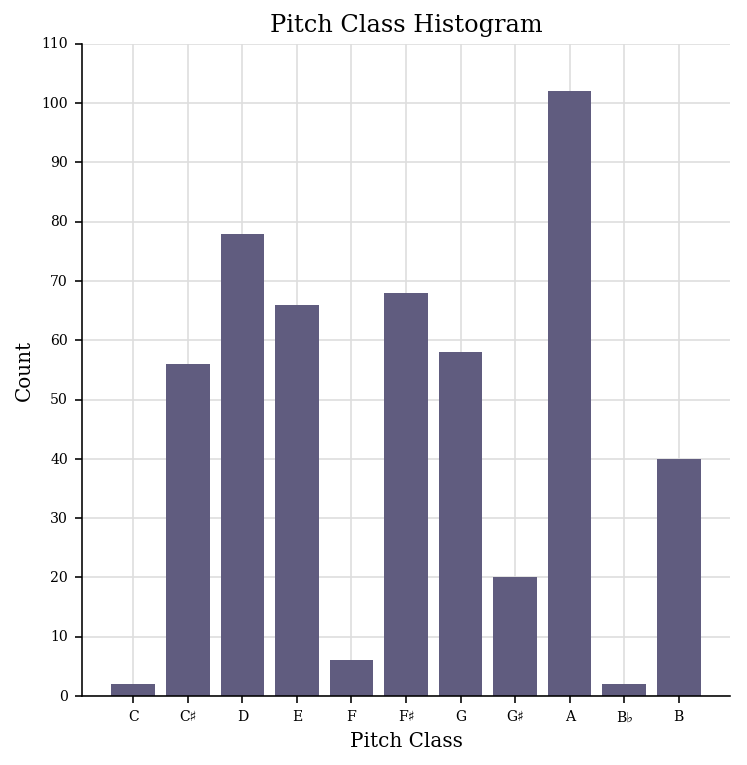

In [160]:
midi2.plot('histogram', 'pitchClass', 'count')

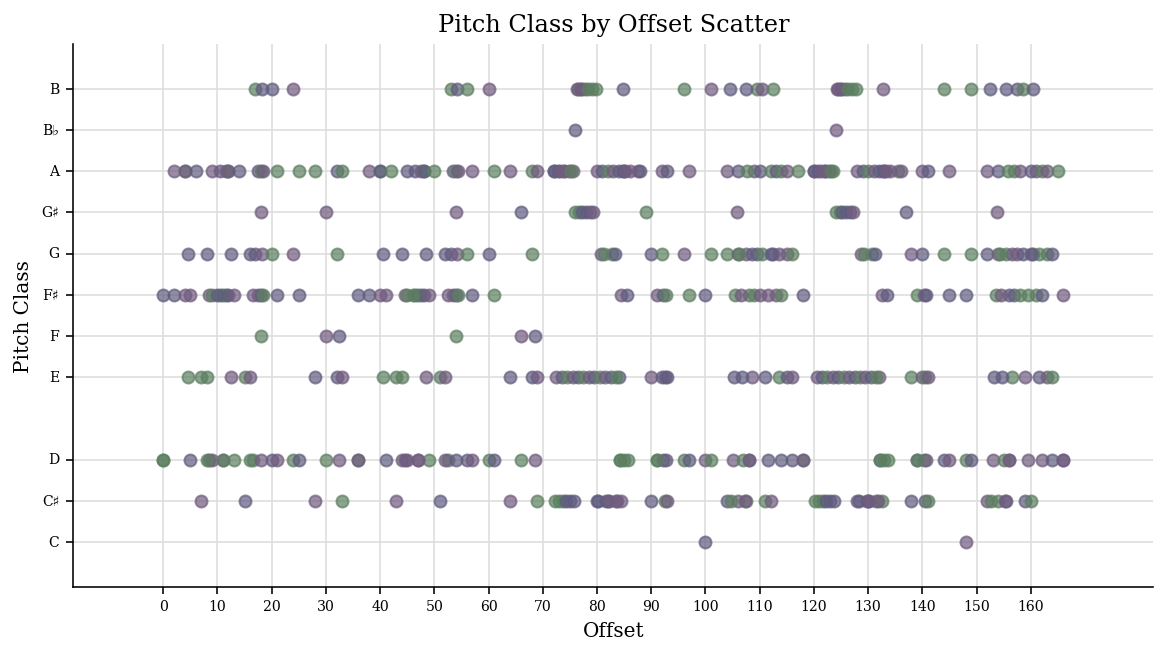

In [161]:
midi2.plot('scatter', 'offset', 'pitchClass')

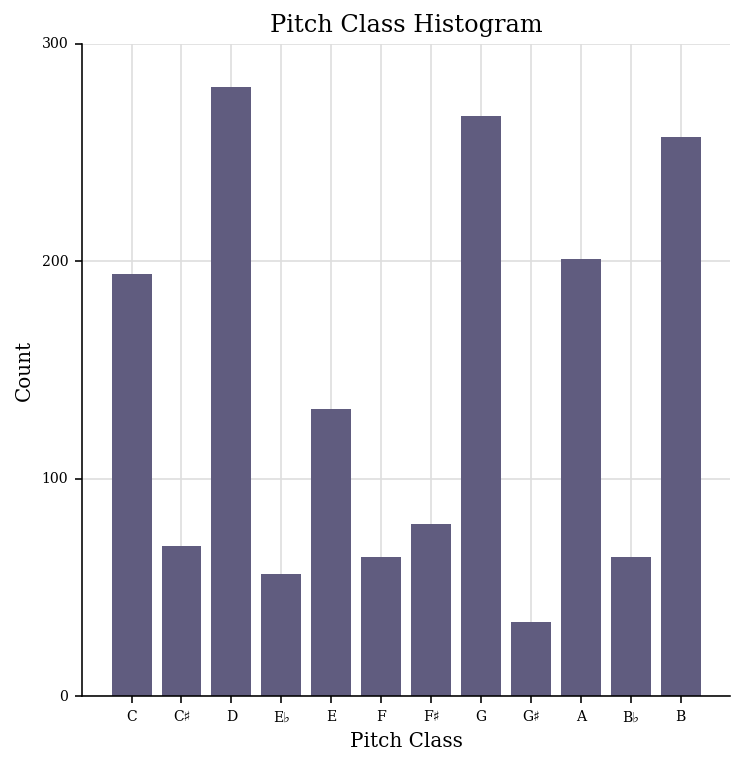

In [162]:
midi3.plot('histogram', 'pitchClass', 'count')

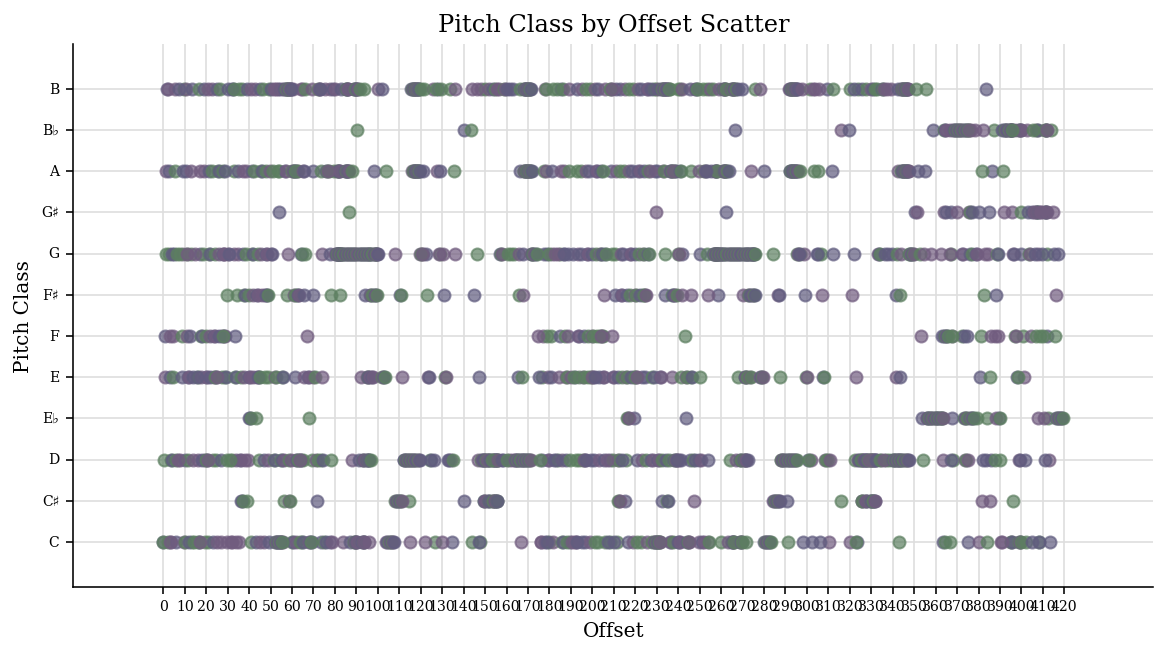

In [163]:
midi3.plot('scatter', 'offset', 'pitchClass')

In [164]:
timeSignature1 = midi1.getTimeSignatures()[0]
music_analysis1 = midi1.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature1.beatCount, timeSignature1.denominator))
print("Expected music key: {0}".format(music_analysis1))
print("Music key confidence: {0}".format(music_analysis1.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis1.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 2/2
Expected music key: A- major
Music key confidence: 0.9429758170162916
Other music key alternatives:
b- minor
C# major
f minor
E- major
g# minor


In [165]:
timeSignature2 = midi2.getTimeSignatures()[0]
music_analysis2 = midi2.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature2.beatCount, timeSignature2.denominator))
print("Expected music key: {0}".format(music_analysis2))
print("Music key confidence: {0}".format(music_analysis2.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis2.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: D major
Music key confidence: 0.9172770750668566
Other music key alternatives:
A major
b minor
G major
d minor
e minor


In [166]:
timeSignature3 = midi3.getTimeSignatures()[0]
music_analysis3 = midi3.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature3.beatCount, timeSignature3.denominator))
print("Expected music key: {0}".format(music_analysis3))
print("Music key confidence: {0}".format(music_analysis3.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis3.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: G major
Music key confidence: 0.8751010053909188
Other music key alternatives:
C major
g minor
a minor


And finaly, bringing the results together.

In [167]:
m1 = ['Soave Il Vento', format(music_analysis1), harmonic_reduction(midi1)[0:10]]
m2 = ['Sonatina n3 1mov', format(music_analysis2), harmonic_reduction(midi2)[0:10]]
m3 = ['K393 Solfeggi n1', format(music_analysis3), harmonic_reduction(midi3)[0:10]]

In [168]:
import numpy
matrix = numpy.array([m1, m2, m3])
df = DataFrame(matrix)

In [169]:
df.head()

,0,1,2
0,Soave Il Vento,A- major,"[#iii64, iii65, iii64, iii65, V53, iii64, vi, ..."
1,Sonatina n3 1mov,D major,"[I, I64, I, I64, I, I, vi43, -III65, V7, I]"
2,K393 Solfeggi n1,G major,"[ii, I53, I, IV53, v42, vi42, -VII42, I, IV42,..."
